***

<center>
 
### ANLY 590 | Homework 2
### Kendra Gedney | kg729@georgetown.edu 

<center>

In [1]:
# set working directory
import os
path = '/Users/kgedney/Documents/georgetown/anly590/anly590-homework'
os.chdir(path)

In [2]:
# prep
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

/Users/kgedney/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Problem 1: Autoencoder

A convolutional autoencoder is a particular flavor of autoencoder where we use convolutional layers instead of dense layers. We have previously applied autoencoders to images using only Dense layers and the result worked fairly well. However, the local spatial correlations of images imply that we should be able to do better using convolutional layers instead of Dense layers.   
   
Build and fit a convolutional autoencoder for the Fashion MNIST dataset. The components of this network will be many of the same pieces we’ve used with convolutional classification networks: Conv2D, MaxPooling, and so on. The encoder part of the network should run the input image through a few convolutional layers of your choice. The decoder part of the network will utilize UpSampling2D to get the representation back to the original image size.   

An example to guide your thinking can be found toward the bottom of this post https://blog.keras.io/building-autoencoders-in-keras.html.
   
After training your network, visualize some examples of input images and their decoded reconstruction.


_For this problem, I used the same network as in the keras blog post about autoencoders. I used a MSE loss function with the Adadelta optimizer. The results were okay -- most of the autoencoded images are recognizable. The differences between Ankle Boot, Sandal and Sneaker are slight._ 

#### Prep Fashion MNIST dataset

In [3]:
# prep
from keras.utils import np_utils

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, UpSampling2D

Using TensorFlow backend.


In [3]:
# load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
# check shapes
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [5]:
# normalize grayscale
x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32') / 255.

# reshape images
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test  = x_test.reshape(x_test.shape[0], 28, 28, 1)

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [0]:
# 10 classes of clothing types - make categorical
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

#### Define and Train Autoencoder Network

In [0]:
# copy network from blog post
input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')

In [0]:
# train network
autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 58s 961us/step - loss: 0.0355 - val_loss: 0.0285
Epoch 2/5
60000/60000 [==============================] - 58s 971us/step - loss: 0.0280 - val_loss: 0.0277
Epoch 3/5
60000/60000 [==============================] - 59s 980us/step - loss: 0.0248 - val_loss: 0.0230
Epoch 4/5
60000/60000 [==============================] - 58s 968us/step - loss: 0.0231 - val_loss: 0.0224
Epoch 5/5
60000/60000 [==============================] - 58s 965us/step - loss: 0.0221 - val_loss: 0.0226


#### Visualize Results

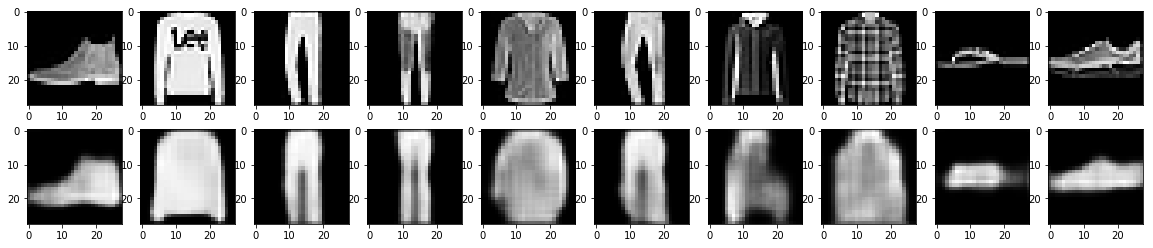

In [0]:
# visualize images before and after decoding
plt.figure(figsize=(20, 4))

n=10
for k in range(n):
    ax = plt.subplot(2, n, k+1)
    plt.imshow(x_test[k:k+1,:].reshape((28,28)), "gray")
    ax = plt.subplot(2, n, k+1 + n)
    reconstruction = autoencoder.predict(x_test[k:k+1,:])
    reconstruction.resize((28,28))
    plt.imshow(reconstruction, "gray")

### Problem 2: Image Classification

#### 2.1: Deep CNN
Build a deep CNN to classify the images. Provide a brief description of the architectural choices you’ve made: kernel sizes, strides, padding, network depth. Train your network end-to-end. Report on your model’s performance on training set and test set.


_The best model I fit achieved 92.39% test accuracy (and 96.02% training accuracy)after 16 epochs. It has two convolutional layers each with: 128 filters, kernel size = (3,3), stride=1, padding='valid, adam optimizer and dropout (0.5)._

_I tested lesser filter sizes, but 128 performed the best. I also tested a kernel size =(5,5) but performance was the same so I left it at (3,3) since it is less computationally expensive. The adam optimizer performed slightly better than sgd and adadelta. Performace was the same with padding so left it as is._ 

_I first fit networks with one convolutional layer, with accuracy around 89-90%, but then added a second layer which improved accuracy up to 92%. Adding the dense layer of size 512 at the end of the model also led to some modest gains._


In [0]:
# define model
model_a = Sequential()

model_a.add(Conv2D(
    filters=128,
    kernel_size=(3, 3), 
    activation='relu',
    strides=(1, 1),
    padding='valid',
    input_shape=(28,28,1)))

model_a.add(MaxPooling2D(pool_size=(2, 2)))

model_a.add(Conv2D(
    filters=128,
    kernel_size=(3, 3), 
    activation='relu',
    strides=(1, 1),
    padding='valid'))

model_a.add(MaxPooling2D(pool_size=(2, 2)))

model_a.add(Dropout(0.5))
model_a.add(Flatten())
model_a.add(Dense(512, activation='relu'))
model_a.add(Dropout(0.5))
model_a.add(Dense(10, activation='softmax'))

In [0]:
model_a.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# fit (ran on google colab, takes about 3 mins)
history_a = model_a.fit(x_train, y_train, batch_size=256, epochs=16, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/16
60000/60000 [==============================] - 10s 165us/step - loss: 0.5936 - acc: 0.7821 - val_loss: 0.4063 - val_acc: 0.8502
Epoch 2/16
60000/60000 [==============================] - 9s 156us/step - loss: 0.3800 - acc: 0.8623 - val_loss: 0.3437 - val_acc: 0.8727
Epoch 3/16
60000/60000 [==============================] - 9s 156us/step - loss: 0.3257 - acc: 0.8806 - val_loss: 0.3090 - val_acc: 0.8870
Epoch 4/16
60000/60000 [==============================] - 9s 155us/step - loss: 0.2998 - acc: 0.8902 - val_loss: 0.2785 - val_acc: 0.8991
Epoch 5/16
60000/60000 [==============================] - 9s 156us/step - loss: 0.2799 - acc: 0.8971 - val_loss: 0.2641 - val_acc: 0.9021
Epoch 6/16
60000/60000 [==============================] - 9s 155us/step - loss: 0.2619 - acc: 0.9022 - val_loss: 0.2565 - val_acc: 0.9058
Epoch 7/16
60000/60000 [==============================] - 9s 155us/step - loss: 0.2486 - acc: 0.9077 - val_loss: 0.2498 -

In [15]:
print(model_a.evaluate(x_test, y_test))
print(model_a.evaluate(x_train, y_train))

10000/10000 [==============================] - 1s 143us/step
[0.21772897923588752, 0.9239]
60000/60000 [==============================] - 8s 139us/step
[0.11143724941834808, 0.9601833333333334]


In [0]:
# check confusion matrix
test_preds      = model_a.predict(x_test, verbose=True, batch_size=512)
test_pred_class = test_preds.argmax(axis=-1)
y_test_class    = y_test.argmax(axis=-1)

pd.crosstab(y_test_class, test_pred_class)

#### 2.2:  Transfer Learning
Repeat the same task, but this time utilize a pre-trained network for the majority of your model. You should only train the final Dense layer, all other weights should be fixed. You can use whichever pre-trained backbone you like (ResNet, VGG, etc). Report on your model’s performance on training set and test set.

_Using the VGG backbone with fine tuning did not improve the results. It still did well - with a 89.09% test accuracy and 94.09% training acurracy. Perhaps the images used to train VGG, ImageNet, are too different from the FashionMNIST dataset to realize any big gains. Others who have used the VGG backbone (as recorded here: https://github.com/zalandoresearch/fashion-mnist) have achieved accuracy rates of 93.5% it seems my results could be improved._

In [0]:
# ref: https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5

In [0]:
# resize images
import cv2
x_train_big = np.asarray([cv2.resize(x, (48,48)) for x in x_train])
x_test_big  = np.asarray([cv2.resize(x, (48,48)) for x in x_test])
# plt.imshow(x_train_big[9], 'gray')

In [0]:
# reshape 
x_train_big = x_train_big.reshape(x_train_big.shape[0], 48, 48,1)
x_test_big  = x_test_big.reshape(x_test_big.shape[0], 48, 48, 1)

# make gray images into rgb images
x_train_big = x_train_big.repeat(3, axis=-1)
x_test_big  = x_test_big.repeat(3, axis=-1)

In [18]:
x_test_big.shape

(10000, 48, 48, 3)

In [19]:
# prep VGG backbone
from keras.applications import VGG16
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(48,48,3))

58892288/58889256 [==============================] - 2s 0us/step


In [0]:
# define model
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dense(10, activation="softmax"))

In [21]:
# freeze weights so that we only train the final layers
conv_base.trainable = False
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5130      
Total params: 14,982,474
Trainable params: 267,786
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["acc"])

In [23]:
# fit (ran on google colab, takes about 10 mins)
model.fit(x_train_big, 
          y_train,
          batch_size=128,
          shuffle=True,
          epochs=16, 
          validation_data=(x_test_big, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/16
60000/60000 [==============================] - 44s 740us/step - loss: 0.5171 - acc: 0.8193 - val_loss: 0.4271 - val_acc: 0.8463
Epoch 2/16
60000/60000 [==============================] - 42s 702us/step - loss: 0.3763 - acc: 0.8631 - val_loss: 0.3887 - val_acc: 0.8599
Epoch 3/16
60000/60000 [==============================] - 42s 701us/step - loss: 0.3437 - acc: 0.8740 - val_loss: 0.3836 - val_acc: 0.8599
Epoch 4/16
60000/60000 [==============================] - 42s 701us/step - loss: 0.3213 - acc: 0.8828 - val_loss: 0.3799 - val_acc: 0.8657
Epoch 5/16
60000/60000 [==============================] - 42s 700us/step - loss: 0.3046 - acc: 0.8876 - val_loss: 0.3715 - val_acc: 0.8664
Epoch 6/16
60000/60000 [==============================] - 42s 702us/step - loss: 0.2873 - acc: 0.8939 - val_loss: 0.3503 - val_acc: 0.8735
Epoch 7/16
60000/60000 [==============================] - 42s 701us/step - loss: 0.2743 - acc: 0.8985 - val_loss: 0.

In [26]:
print(model.evaluate(x_test_big, y_test))
print(model.evaluate(x_train_big, y_train))

10000/10000 [==============================] - 9s 879us/step
[0.33660674959421155, 0.8909]
60000/60000 [==============================] - 53s 875us/step
[0.16318389824877183, 0.9409166666666666]


### Problem 3: Text Classification

While images contain local spatial correlations and structure, many other datasets contain temporal correlations. Examples include time series and discrete se- quences such as text. In this problem, we will tackle the task of text classification in the context of cybersecurity.

Background:   
When malware infects a host computer, it often needs to reach out to an outside server for further instructions or to download additional payloads. This outside server is called a Command-and-Control server (C2). The malware needs to send a specific communication to the C2 server, thus the C2 server needs to have a registered IP address or associated web domain so that it can be reached. Therefore, being able to identify web domains that are likely related to malware C2 can be a valuable cyber defense.

Dataset:   
Fortunately, security researchers have already identified and logged a large number of malicious URLs. Additionally, we can catalog common ”benign” URLs just from typical web behavior (these would include things like facebook.com and amazon.com). Hence, we have a labeled dataset for text classification which can be downloaded here:
-  https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt
- https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt

#### Data Prep

In [76]:
# import packages
import requests
from sklearn.model_selection import train_test_split

In [63]:
url_good = 'https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt'
url_mal  = 'https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt'

In [64]:
r_good = requests.get(url_good).text
r_mal  = requests.get(url_mal).text

In [72]:
good_urls = list(r_good.split("\n"))[1:]
mal_urls  = list(r_mal.split("\n"))
urls_list = good_urls + mal_urls
len(urls_list)

In [66]:
# add in classes (0=benign, 1=mal)
print(len(good_urls))
print(len(mal_urls))
class_list = [0]*66056 + [1]*1297
print(len(class_list))

66056

In [77]:
# split test and train
x_train, x_test, y_train, y_test = train_test_split(urls_list, class_list, test_size=0.33, random_state=480)

In [103]:
# check results
print(y_train.count(0), y_train.count(1))
print(len([x for x in x_train if x in mal_urls]))

44258 868
868


#### 3.1: RNN
Build and train a Recurrent Neural Network to solve this text classification task. You can use any type of RNN you wish (SimpleRNN, GRU, LSTM).

'.box5656.bluehost.com'

#### 3.2: CNN
Build and train a 1D CNN for this text classification task. You might gain some insight and inspiration from these text classification approaches:
-  http://www.aclweb.org/anthology/D14-1181 
-  https://arxiv.org/abs/1702.08568